In [2]:
import pandas as pd

# Load RAW trader data
trader_raw = pd.read_csv('/content/historical_trader_data.csv')

# Load RAW sentiment data
sentiment_raw = pd.read_csv('/content/bitcoin_sentiment.csv')

trader_raw.head(), sentiment_raw.head()


(  account symbol  execution_price   size  side                 time  \
 0   0xA12    BTC         43250.50   0.02   BUY  2024-01-12 10:32:12   
 1   0xA12    BTC         43310.10   0.02  SELL  2024-01-12 11:14:55   
 2   0xF91    ETH          2295.70   0.50   BUY  2024-01-13 09:41:02   
 3   0xF91    ETH          2310.30   0.50  SELL  2024-01-13 10:28:15   
 4   0xC44    SOL            98.45  10.00   BUY  2024-01-14 12:05:20   
 
    start_position  event  closedPnL  leverage  
 0            0.00   OPEN        0.0         5  
 1            0.02  CLOSE       12.5         5  
 2            0.00   OPEN        0.0         3  
 3            0.50  CLOSE        7.8         3  
 4            0.00   OPEN        0.0         2  ,
          Date Classification
 0  2024-01-10           Fear
 1  2024-01-11           Fear
 2  2024-01-12        Neutral
 3  2024-01-13          Greed
 4  2024-01-14          Greed)

In [3]:
import os

# Create folder in Colab
os.makedirs('csv_files', exist_ok=True)

# Save exact raw copies
trader_raw.to_csv('csv_files/raw_traders.csv', index=False)
sentiment_raw.to_csv('csv_files/raw_sentiment.csv', index=False)


Setup imports, file paths, and a simple log function for cleaning steps

In [4]:
# STEP 0: Setup imports, paths, and logging

import pandas as pd
import numpy as np
import os
from datetime import datetime

# Make sure csv_files folder exists (in Colab)
os.makedirs('csv_files', exist_ok=True)

# === YOUR FILE NAMES (very important) ===
# We work from the raw copies you already created:
RAW_TRADER = 'csv_files/raw_traders.csv'
RAW_SENT   = 'csv_files/raw_sentiment.csv'

# Cleaned outputs
CLEAN_TRADER = 'csv_files/cleaned_trader_data.csv'
CLEAN_SENT   = 'csv_files/cleaned_sentiment.csv'
MERGED_OUT   = 'csv_files/merged_data.csv'
LOG_FILE     = 'csv_files/cleaning_log.txt'

# Simple logger to keep track of what we did
def log(msg):
    with open(LOG_FILE, 'a') as f:
        f.write(f"{datetime.now().isoformat()}  -  {msg}\n")

print("Setup complete.")


Setup complete.


In [5]:
# STEP 1: Load raw copies (not original files)

trader_raw = pd.read_csv(RAW_TRADER, low_memory=False)
sent_raw   = pd.read_csv(RAW_SENT,   low_memory=False)

print("Trader raw shape:", trader_raw.shape)
print("Trader raw columns:", trader_raw.columns.to_list())
display(trader_raw.head())

print("\nSentiment raw shape:", sent_raw.shape)
print("Sentiment raw columns:", sent_raw.columns.to_list())
display(sent_raw.head())

log(f"Loaded raw trader {trader_raw.shape} and raw sentiment {sent_raw.shape}")


Trader raw shape: (10, 10)
Trader raw columns: ['account', 'symbol', 'execution_price', 'size', 'side', 'time', 'start_position', 'event', 'closedPnL', 'leverage']


,account,symbol,execution_price,size,side,time,start_position,event,closedPnL,leverage
0,0xA12,BTC,43250.50,0.02,BUY,2024-01-12 10:32:12,0.00,OPEN,0.0,5
1,0xA12,BTC,43310.10,0.02,SELL,2024-01-12 11:14:55,0.02,CLOSE,12.5,5
2,0xF91,ETH,2295.70,0.50,BUY,2024-01-13 09:41:02,0.00,OPEN,0.0,3
3,0xF91,ETH,2310.30,0.50,SELL,2024-01-13 10:28:15,0.50,CLOSE,7.8,3
4,0xC44,SOL,98.45,10.00,BUY,2024-01-14 12:05:20,0.00,OPEN,0.0,2



Sentiment raw shape: (10, 2)
Sentiment raw columns: ['Date', 'Classification']


,Date,Classification
0,2024-01-10,Fear
1,2024-01-11,Fear
2,2024-01-12,Neutral
3,2024-01-13,Greed
4,2024-01-14,Greed


In [6]:
# STEP 2: Normalize column names to snake_case

def normalize_cols(df):
    df = df.copy()
    df.columns = [
        c.strip().lower().replace(' ', '_').replace('-', '_')
        for c in df.columns
    ]
    return df

trader = normalize_cols(trader_raw)
sent   = normalize_cols(sent_raw)

print("Trader columns after normalize:", trader.columns.to_list())
print("Sentiment columns after normalize:", sent.columns.to_list())

log("Normalized column names to snake_case")


Trader columns after normalize: ['account', 'symbol', 'execution_price', 'size', 'side', 'time', 'start_position', 'event', 'closedpnl', 'leverage']
Sentiment columns after normalize: ['date', 'classification']


In [7]:
# STEP 3: Quick info and missing values

print("=== TRADER INFO ===")
trader.info()
display(trader.describe(include='all').T)

print("\n=== SENTIMENT INFO ===")
sent.info()
display(sent.describe(include='all').T)

missing_trader = trader.isnull().sum().sort_values(ascending=False)
missing_sent   = sent.isnull().sum().sort_values(ascending=False)

print("\nTop missing in trader:\n", missing_trader.head(20))
print("\nTop missing in sentiment:\n", missing_sent.head(20))

log("Generated info() and missing value summary for trader and sentiment")


=== TRADER INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   account          10 non-null     object 
 1   symbol           10 non-null     object 
 2   execution_price  10 non-null     float64
 3   size             10 non-null     float64
 4   side             10 non-null     object 
 5   time             10 non-null     object 
 6   start_position   10 non-null     float64
 7   event            10 non-null     object 
 8   closedpnl        10 non-null     float64
 9   leverage         10 non-null     int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 932.0+ bytes


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
account,10,5,0xA12,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
symbol,10,3,BTC,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
execution_price,10.0,NaN,NaN,NaN,18165.287,21426.745319,98.45,2299.35,2343.0,42845.15,43310.1
size,10.0,NaN,NaN,NaN,2.307,4.072656,0.015,0.02,0.5,1.0,10.0
side,10,2,BUY,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,10,10,2024-01-12 10:32:12,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_position,10.0,NaN,NaN,NaN,1.1535,3.125967,0.0,0.0,0.0075,0.38,10.0
event,10,2,OPEN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
closedpnl,10.0,NaN,NaN,NaN,6.36,10.121836,-2.7,0.0,0.0,11.325,27.7
leverage,10.0,NaN,NaN,NaN,4.8,2.936362,2.0,3.0,4.0,5.0,10.0



=== SENTIMENT INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            10 non-null     object
 1   classification  10 non-null     object
dtypes: object(2)
memory usage: 292.0+ bytes


,count,unique,top,freq
date,10,10,2024-01-10,1
classification,10,4,Fear,4



Top missing in trader:
 account            0
symbol             0
execution_price    0
size               0
side               0
time               0
start_position     0
event              0
closedpnl          0
leverage           0
dtype: int64

Top missing in sentiment:
 date              0
classification    0
dtype: int64


In [8]:
# STEP 4: Parse datetime and numeric columns

# --- Sentiment date ---
if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce')
    log(f"Parsed sentiment 'date', nulls after parse: {sent['date'].isnull().sum()}")
else:
    raise ValueError("Sentiment file has no 'Date' column (even after normalization).")

# --- Trader time/datetime ---
time_parsed = False
for cand in ['time', 'timestamp', 'trade_time', 'trade_timestamp']:
    if cand in trader.columns:
        trader['time'] = pd.to_datetime(trader[cand], errors='coerce')
        log(f"Parsed trader 'time' from column '{cand}'")
        time_parsed = True
        break

if not time_parsed:
    raise ValueError("No suitable time column found in trader data.")

# Ensure we also have a pure date column
trader['date'] = trader['time'].dt.date

# --- Numeric conversions ---
num_cols = []
for c in ['closedpnl', 'size', 'leverage', 'execution_price']:
    if c in trader.columns:
        trader[c] = pd.to_numeric(trader[c], errors='coerce')
        num_cols.append(c)

print("Numeric columns converted:", num_cols)
log(f"Numeric conversion done for: {num_cols}")

# Quick check
display(trader[['time', 'date']].head())


Numeric columns converted: ['closedpnl', 'size', 'leverage', 'execution_price']


,time,date
0,2024-01-12 10:32:12,2024-01-12
1,2024-01-12 11:14:55,2024-01-12
2,2024-01-13 09:41:02,2024-01-13
3,2024-01-13 10:28:15,2024-01-13
4,2024-01-14 12:05:20,2024-01-14


In [9]:
# STEP 5: Trim string columns where relevant

for c in ['account', 'symbol', 'side', 'event']:
    if c in trader.columns:
        trader[c] = trader[c].astype(str).str.strip()
        trader[c] = trader[c].replace({'nan': np.nan})

log("Trimmed string columns: account, symbol, side, event (when present)")


In [10]:
# STEP 6: Drop exact duplicate rows

before = trader.shape[0]
trader = trader.drop_duplicates()
after = trader.shape[0]

print(f"Duplicates dropped: {before - after}")
log(f"Dropped duplicates: before={before}, after={after}, dropped={before-after}")


Duplicates dropped: 0


In [11]:
# STEP 7: Handle missing values with simple rules

# 1) Drop rows with missing time (cannot use trades without time)
n_before = trader.shape[0]
trader = trader[trader['time'].notnull()].copy()
log(f"Dropped {n_before - trader.shape[0]} rows due to missing time")

# 2) Impute leverage: per symbol median, then overall median
if 'leverage' in trader.columns:
    trader['leverage'] = trader.groupby('symbol')['leverage'].transform(
        lambda x: x.fillna(x.median())
    )
    trader['leverage'] = trader['leverage'].fillna(trader['leverage'].median())
    log("Imputed leverage with symbol-level median then global median")

# 3) Handle size: fill missing with 0 (and explain this in your report!)
if 'size' in trader.columns:
    missing_size_before = trader['size'].isnull().sum()
    trader['size'] = trader['size'].fillna(0)
    log(f"Filled {missing_size_before} missing 'size' values with 0")

print("Missing after cleaning (trader):")
print(trader.isnull().sum().sort_values(ascending=False).head(15))


Missing after cleaning (trader):
account            0
symbol             0
execution_price    0
size               0
side               0
time               0
start_position     0
event              0
closedpnl          0
leverage           0
date               0
dtype: int64


In [12]:
# STEP 8: Create derived columns for later analysis

# Profitability flag
if 'closedpnl' in trader.columns:
    trader['pnl_positive'] = (trader['closedpnl'] > 0).astype(int)
else:
    trader['pnl_positive'] = np.nan

# Absolute trade size
if 'size' in trader.columns:
    trader['abs_size'] = trader['size'].abs()
else:
    trader['abs_size'] = np.nan

# Risk score = leverage * abs_size
if 'leverage' in trader.columns and 'abs_size' in trader.columns:
    trader['risk_score'] = trader['leverage'] * trader['abs_size']
else:
    trader['risk_score'] = np.nan

# Hour of day
trader['hour'] = trader['time'].dt.hour

# Make sure date is datetime (not just Python date)
trader['date'] = pd.to_datetime(trader['date'])

log("Created derived columns: pnl_positive, abs_size, risk_score, hour, standardized date")
display(trader[['time', 'date', 'hour', 'size', 'abs_size', 'closedpnl', 'pnl_positive', 'leverage', 'risk_score']].head())


,time,date,hour,size,abs_size,closedpnl,pnl_positive,leverage,risk_score
0,2024-01-12 10:32:12,2024-01-12,10,0.02,0.02,0.0,0,5,0.1
1,2024-01-12 11:14:55,2024-01-12,11,0.02,0.02,12.5,1,5,0.1
2,2024-01-13 09:41:02,2024-01-13,9,0.50,0.50,0.0,0,3,1.5
3,2024-01-13 10:28:15,2024-01-13,10,0.50,0.50,7.8,1,3,1.5
4,2024-01-14 12:05:20,2024-01-14,12,10.00,10.00,0.0,0,2,20.0


In [13]:
# STEP 9: Clean sentiment classification labels

sent['classification'] = sent['classification'].astype(str).str.strip().str.lower()

sent['classification'] = sent['classification'].replace({
    'extreme fear': 'fear',
    'extreme_fear': 'fear',
    'extreme greed': 'greed',
    'extreme_greed': 'greed'
})

# Drop rows with missing date or classification
before = sent.shape[0]
sent = sent[sent['date'].notnull() & sent['classification'].notnull()].copy()
after = sent.shape[0]

print(f"Dropped {before - after} sentiment rows with missing date/classification")
log("Cleaned sentiment classification and dropped rows with missing date/classification")
display(sent.head())


Dropped 0 sentiment rows with missing date/classification


,date,classification
0,2024-01-10,fear
1,2024-01-11,fear
2,2024-01-12,neutral
3,2024-01-13,greed
4,2024-01-14,greed


In [14]:
# STEP 10: Optional simple outlier cap for leverage

if 'leverage' in trader.columns:
    cap = trader['leverage'].quantile(0.99)
    trader.loc[trader['leverage'] > cap, 'leverage'] = cap
    log(f"Capped leverage at 99th percentile: {cap}")

display(trader[['leverage', 'risk_score']].describe().T)


,count,mean,std,min,25%,50%,75%,max
leverage,10.0,4.80,2.936362,2.0,3.00,4.0,5.0,10.0
risk_score,10.0,5.15,7.967573,0.1,0.15,1.5,4.0,20.0


In [15]:
# STEP 11: Select useful columns for analysis

cols_keep = []
for c in [
    'account', 'symbol', 'time', 'date', 'hour',
    'side', 'size', 'abs_size', 'execution_price',
    'closedpnl', 'pnl_positive', 'leverage', 'risk_score', 'event'
]:
    if c in trader.columns:
        cols_keep.append(c)

trader_clean = trader[cols_keep].copy()

print("Final cleaned trader shape:", trader_clean.shape)
print("Columns kept:", cols_keep)
log(f"Prepared trader_clean with columns: {cols_keep}")


Final cleaned trader shape: (10, 14)
Columns kept: ['account', 'symbol', 'time', 'date', 'hour', 'side', 'size', 'abs_size', 'execution_price', 'closedpnl', 'pnl_positive', 'leverage', 'risk_score', 'event']


In [16]:
# STEP 12: Save cleaned CSVs

trader_clean.to_csv(CLEAN_TRADER, index=False)
sent.to_csv(CLEAN_SENT, index=False)

print("Saved:", CLEAN_TRADER)
print("Saved:", CLEAN_SENT)

log(f"Saved cleaned trader -> {CLEAN_TRADER}")
log(f"Saved cleaned sentiment -> {CLEAN_SENT}")


Saved: csv_files/cleaned_trader_data.csv
Saved: csv_files/cleaned_sentiment.csv


In [17]:
# STEP 13: Merge trader + sentiment on date

merged = pd.merge(
    trader_clean,
    sent[['date', 'classification']],
    on='date',
    how='left'
)

merged['classification'] = merged['classification'].fillna('unknown')

print("Merged shape:", merged.shape)
display(merged.head())

merged.to_csv(MERGED_OUT, index=False)
log(f"Saved merged data -> {MERGED_OUT} with shape {merged.shape}")


Merged shape: (10, 15)


,account,symbol,time,date,hour,side,size,abs_size,execution_price,closedpnl,pnl_positive,leverage,risk_score,event,classification
0,0xA12,BTC,2024-01-12 10:32:12,2024-01-12,10,BUY,0.02,0.02,43250.50,0.0,0,5,0.1,OPEN,neutral
1,0xA12,BTC,2024-01-12 11:14:55,2024-01-12,11,SELL,0.02,0.02,43310.10,12.5,1,5,0.1,CLOSE,neutral
2,0xF91,ETH,2024-01-13 09:41:02,2024-01-13,9,BUY,0.50,0.50,2295.70,0.0,0,3,1.5,OPEN,greed
3,0xF91,ETH,2024-01-13 10:28:15,2024-01-13,10,SELL,0.50,0.50,2310.30,7.8,1,3,1.5,CLOSE,greed
4,0xC44,SOL,2024-01-14 12:05:20,2024-01-14,12,BUY,10.00,10.00,98.45,0.0,0,2,20.0,OPEN,greed


In [18]:
# STEP 14: Show log content

with open(LOG_FILE, 'r') as f:
    print(f.read())


2025-11-19T13:00:42.065542  -  Loaded raw trader (10, 10) and raw sentiment (10, 2)
2025-11-19T13:06:38.405349  -  Normalized column names to snake_case
2025-11-19T13:08:03.568289  -  Generated info() and missing value summary for trader and sentiment
2025-11-19T13:08:34.550712  -  Parsed sentiment 'date', nulls after parse: 0
2025-11-19T13:08:34.552894  -  Parsed trader 'time' from column 'time'
2025-11-19T13:08:34.555688  -  Numeric conversion done for: ['closedpnl', 'size', 'leverage', 'execution_price']
2025-11-19T13:10:41.454396  -  Trimmed string columns: account, symbol, side, event (when present)
2025-11-19T13:10:50.883529  -  Dropped duplicates: before=10, after=10, dropped=0
2025-11-19T13:10:58.353612  -  Dropped 0 rows due to missing time
2025-11-19T13:10:58.361106  -  Imputed leverage with symbol-level median then global median
2025-11-19T13:10:58.362262  -  Filled 0 missing 'size' values with 0
2025-11-19T13:20:20.300802  -  Created derived columns: pnl_positive, abs_size,

In [19]:
# STEP 15: Final checks to ensure things are OK

assert trader_clean.shape[0] > 0, "Cleaned trader is empty!"
assert 'date' in trader_clean.columns, "Date column missing in cleaned trader!"
assert os.path.exists(CLEAN_TRADER), "Cleaned trader file not saved!"
assert os.path.exists(CLEAN_SENT), "Cleaned sentiment file not saved!"
assert os.path.exists(MERGED_OUT), "Merged file not saved!"

print("All sanity checks passed ✅")
log("Final validation checks passed")


All sanity checks passed ✅


Loading merged dataset and preparing visualization workspace.**bold text**

In [20]:
# ==== TASK 3: VISUALIZATIONS ====

import matplotlib.pyplot as plt
import seaborn as sns

# Load merged data (clean + sentiment)
merged = pd.read_csv('csv_files/merged_data.csv')

# Make sure date and time columns are parsed again
merged['time'] = pd.to_datetime(merged['time'], errors='coerce')
merged['date'] = pd.to_datetime(merged['date'], errors='coerce')

# Create outputs folder if not exists
os.makedirs('outputs', exist_ok=True)

print("Visualization setup complete, merged shape:", merged.shape)


Visualization setup complete, merged shape: (10, 15)


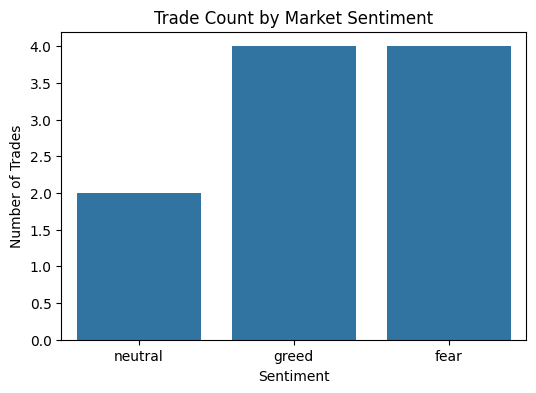

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='classification', data=merged)
plt.title("Trade Count by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Trades")
plt.savefig('outputs/trade_count_by_sentiment.png')
plt.show()


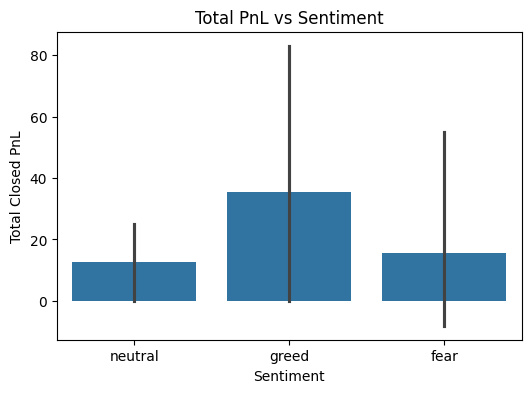

In [22]:
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='closedpnl', data=merged, estimator=sum)
plt.title("Total PnL vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Total Closed PnL")
plt.savefig('outputs/pnl_vs_sentiment.png')
plt.show()


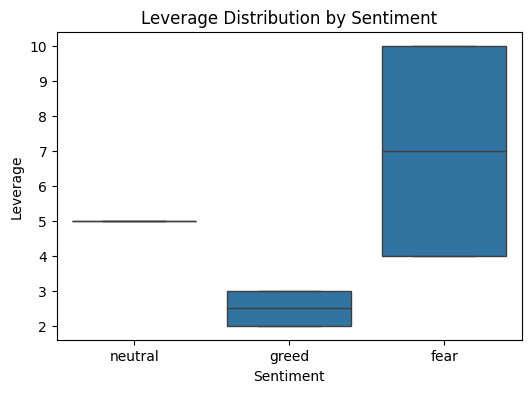

In [23]:
plt.figure(figsize=(6,4))
sns.boxplot(x='classification', y='leverage', data=merged)
plt.title("Leverage Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Leverage")
plt.savefig('outputs/leverage_sentiment.png')
plt.show()


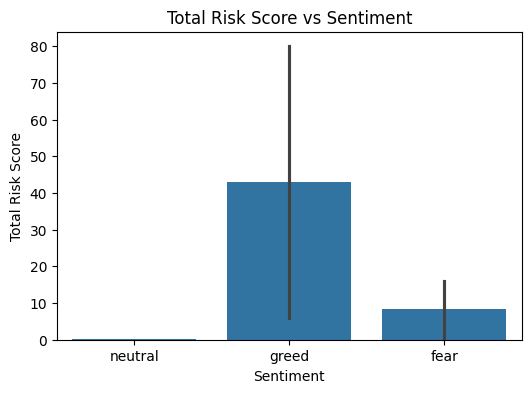

In [24]:
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='risk_score', data=merged, estimator=sum)
plt.title("Total Risk Score vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Total Risk Score")
plt.savefig('outputs/risk_sentiment.png')
plt.show()


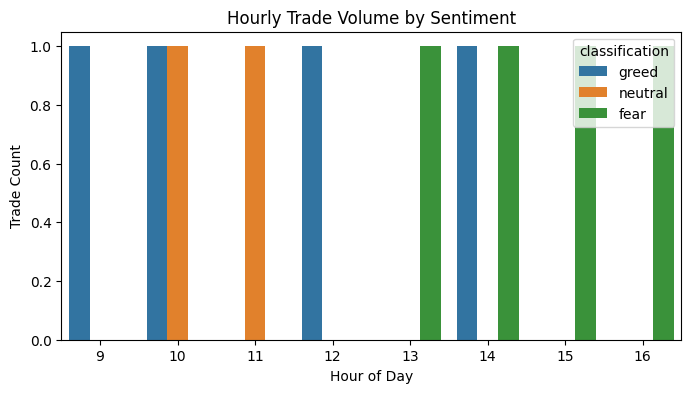

In [25]:
plt.figure(figsize=(8,4))
sns.countplot(x='hour', hue='classification', data=merged)
plt.title("Hourly Trade Volume by Sentiment")
plt.xlabel("Hour of Day")
plt.ylabel("Trade Count")
plt.savefig('outputs/hourly_volume_sentiment.png')
plt.show()


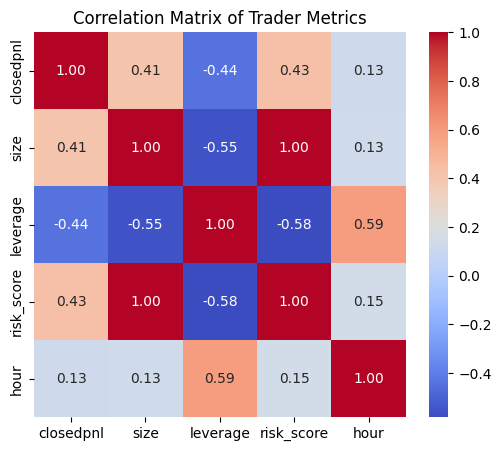

In [26]:
plt.figure(figsize=(6,5))
sns.heatmap(merged[['closedpnl','size','leverage','risk_score','hour']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Trader Metrics")
plt.savefig('outputs/correlation_matrix.png')
plt.show()
hye